### Enhanced Preprocessing with Date Alignment and Filtering

This script performs advanced preprocessing on `unlabeled_data.csv` by selecting key features (**Earnings_Surprise**, **Firm_Size**, and **method_2**) and targets (**CAR_3_Days**, **CAR_10_Days**, **CAR_30_Days**), while preserving the **Earnings_Call_Date** column for contextual reference. It handles missing values by dropping rows with excessive missingness and imputing the rest with column means. Features are standardized using **z-score normalization**, and outliers are filtered using both **IQR** and **Z-score** methods. The cleaned dataset is then realigned with the original data to retain consistency, ensuring only valid, filtered records remain for further analysis or modeling.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# Read data
df = pd.read_csv("unlabeled_data.csv")  # Replace with your CSV file name

df_original = df.copy()

# Store the Earnings_Call_Date column separately
if "Earnings_Call_Date" in df.columns:
    earnings_call_date = df["Earnings_Call_Date"]
    df = df.drop(columns=["Earnings_Call_Date"])  
else:
    earnings_call_date = None  

# Select only the relevant columns for preprocessing
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]
df = df[feature_cols + target_cols]  # Keep only selected columns

# Handling Missing Values 
missing_threshold = 0.2  # Maximum allowed missing ratio per row
df = df.dropna(thresh=int(len(df.columns) * missing_threshold))  # Drop rows with excessive missing values
df = df.fillna(df.mean())  # Fill remaining missing values with mean

# Standardization 
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# Outlier handling using the IQR method
Q1 = df[feature_cols].quantile(0.25)
Q3 = df[feature_cols].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[~((df[feature_cols] < lower_bound) | (df[feature_cols] > upper_bound)).any(axis=1)]

# Using the Z-score method for further outlier detection
z_scores = np.abs(zscore(df[feature_cols]))
df = df[(z_scores < 3).all(axis=1)]  # Remove rows where any feature has a Z-score > 3

# Reattach the Earnings_Call_Date column
if earnings_call_date is not None:
    df["Earnings_Call_Date"] = earnings_call_date.loc[df.index]  # Ensure alignment

# Keep only the relevant columns
df = df[["Earnings_Call_Date"] + feature_cols + target_cols]  # Ensure the order

print(df.head())

# Remove instances in original_df that are NOT in df
df_original = df_original[df_original[target_cols].apply(tuple, axis=1).isin(df[target_cols].apply(tuple, axis=1))]

  Earnings_Call_Date  Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  \
0         2020-01-08          -0.015581  -0.208570  1.766057   -0.014271   
1         2020-01-08          -0.023933  -0.338141  0.071589   -0.008348   
2         2020-01-22          -0.009249  -0.339219  0.282063    0.094707   
4         2020-01-23          -0.028122  -0.322995 -1.021321    0.017126   
5         2020-01-24          -0.024730  -0.124929  0.153801   -0.021278   

   CAR_10_Days  CAR_30_Days  
0     0.010221     0.083406  
1    -0.026677    -0.059266  
2     0.089449     0.049796  
4     0.026210    -0.054972  
5     0.016655    -0.013365  


### Optimal Cluster Selection for GMM Clustering

This script applies **Gaussian Mixture Models (GMM)** to identify the optimal number of clusters (K) for the preprocessed dataset using three evaluation metrics: **BIC**, **AIC**, and **Silhouette Score**. It tests K values from 2 to 10, plots BIC and AIC curves to visualize the elbow point, and also computes silhouette scores to measure cluster quality. These visualizations guide manual selection of the most appropriate number of clusters for downstream analysis or strategy development.


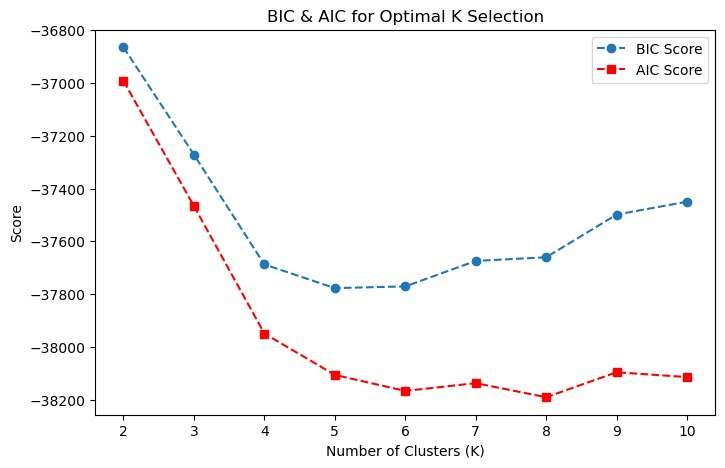

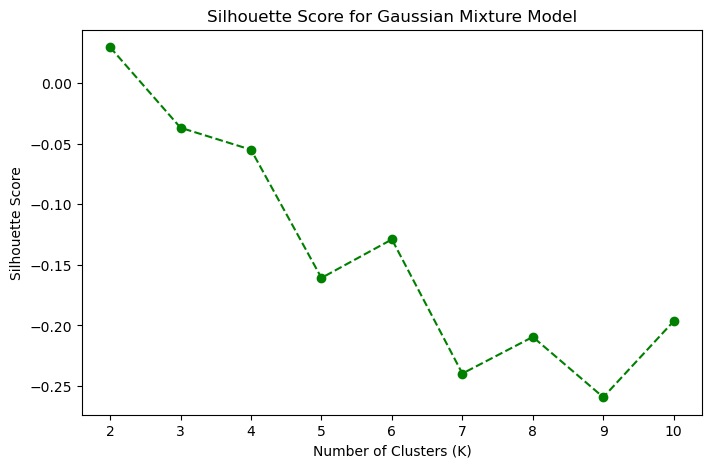

Check the graphs above and manually select the best K in the next step.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

X = df[feature_cols]

#Using the Elbow Method with Gaussian Mixture Model (BIC and AIC for Optimal K) 
bic_scores = []  # Bayesian Information Criterion (BIC)
aic_scores = []  # Akaike Information Criterion (AIC)
K_range = range(2, 11)  # Test cluster counts from 2 to 10

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))  # BIC Score
    aic_scores.append(gmm.aic(X))  # AIC Score

# Plot BIC and AIC Scores to Find Optimal K
plt.figure(figsize=(8, 5))
plt.plot(K_range, bic_scores, marker="o", linestyle="--", label="BIC Score")
plt.plot(K_range, aic_scores, marker="s", linestyle="--", label="AIC Score", color="r")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Score")
plt.title("BIC & AIC for Optimal K Selection")
plt.legend()
plt.show()

# Calculating Silhouette Score for Gaussian Mixture Model
silhouette_scores = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    labels = gmm.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker="o", linestyle="--", color="g")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Gaussian Mixture Model")
plt.show()

print("Check the graphs above and manually select the best K in the next step.")


### GMM Clustering and CAR Interpretation (K = 3, 4, 5)

This script applies **Gaussian Mixture Models (GMM)** to cluster the preprocessed dataset using **Earnings_Surprise**, **Firm_Size**, and **method_2** as input features. It evaluates models with **K = 3, 4, and 5** clusters, computes **silhouette scores** to assess clustering quality, and visualizes the results using scatter plots.

To evaluate how well the clusters capture **post-earnings stock behavior**, the script calculates and plots the **mean Cumulative Abnormal Returns (CAR)** over 3, 10, and 30 days for each cluster. These insights help interpret the financial significance of the clusters and support strategy development based on cluster behavior.


Silhouette Score for K=3: -0.0369


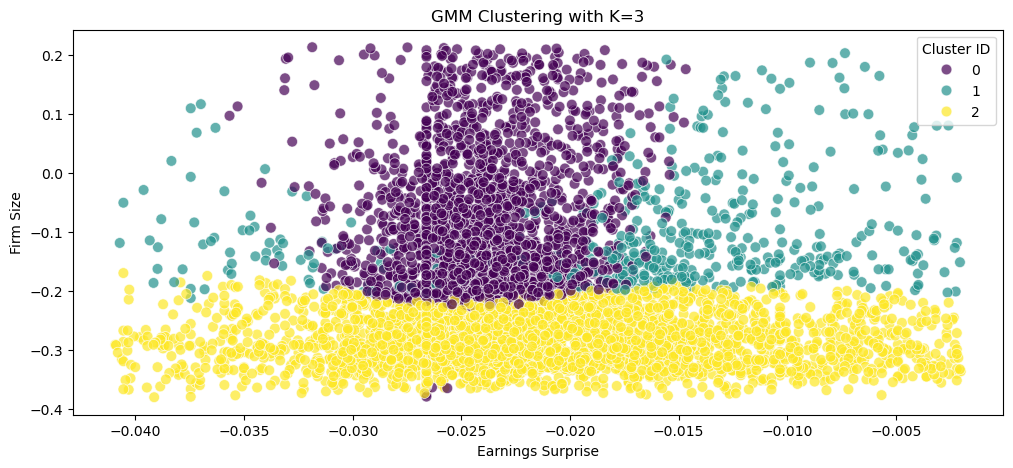

<Figure size 1200x400 with 0 Axes>

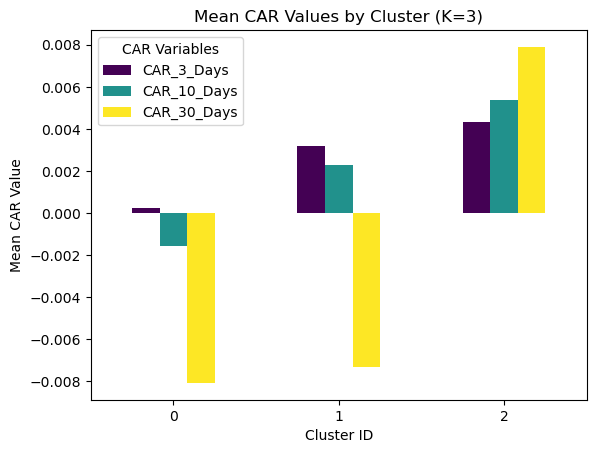

Mean CAR values for K=3:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_3                                      
0            0.000261    -0.001544    -0.008078
1            0.003189     0.002297    -0.007319
2            0.004334     0.005350     0.007897
--------------------------------------------------
Silhouette Score for K=4: -0.0551


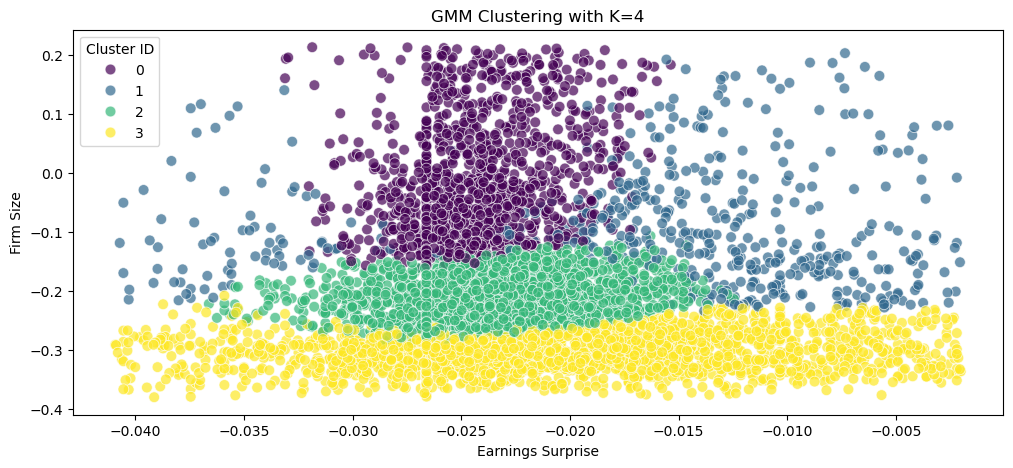

<Figure size 1200x400 with 0 Axes>

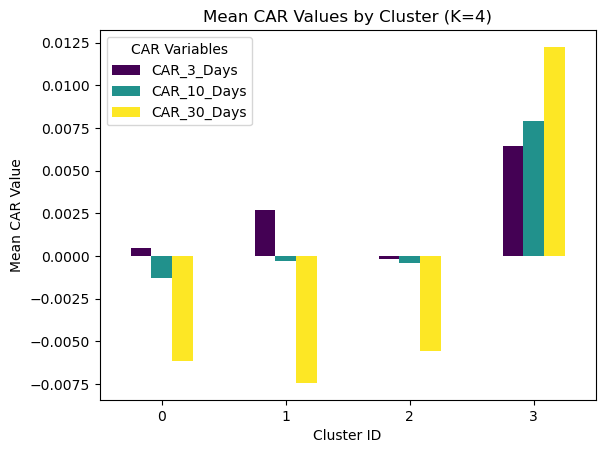

Mean CAR values for K=4:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_4                                      
0            0.000500    -0.001258    -0.006137
1            0.002720    -0.000277    -0.007431
2           -0.000183    -0.000435    -0.005539
3            0.006473     0.007928     0.012247
--------------------------------------------------
Silhouette Score for K=5: -0.1608


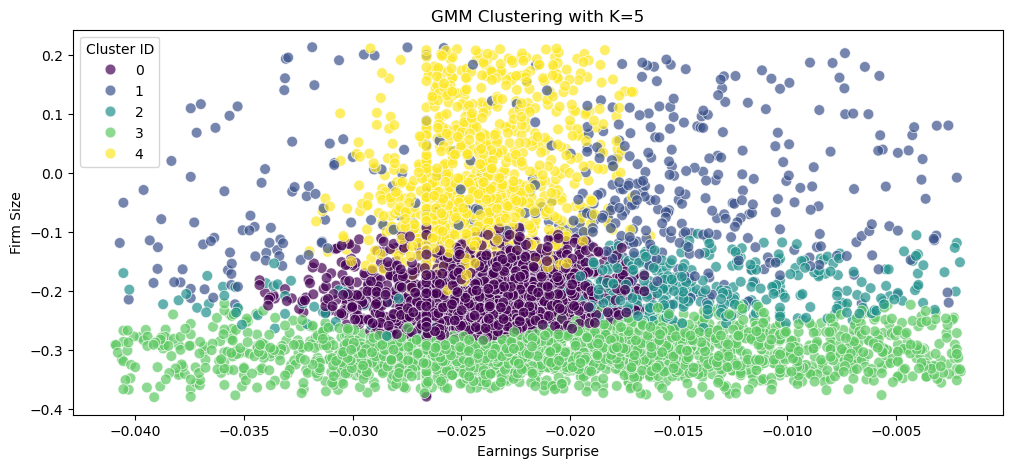

<Figure size 1200x400 with 0 Axes>

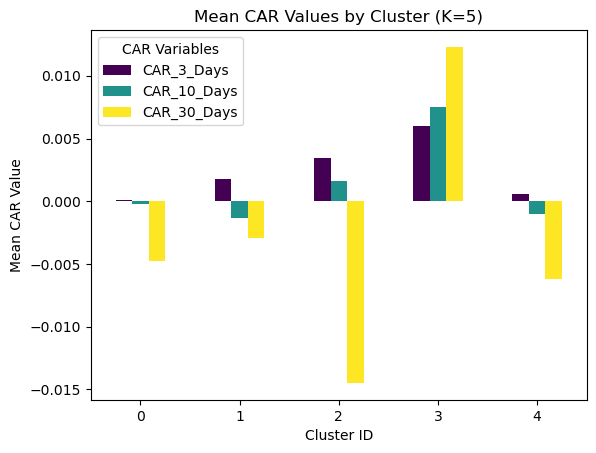

Mean CAR values for K=5:
           CAR_3_Days  CAR_10_Days  CAR_30_Days
Cluster_5                                      
0            0.000097    -0.000206    -0.004752
1            0.001735    -0.001328    -0.002959
2            0.003428     0.001575    -0.014478
3            0.005974     0.007515     0.012298
4            0.000596    -0.001002    -0.006220
--------------------------------------------------
  Earnings_Call_Date  Earnings_Surprise  Firm_Size  method_2  CAR_3_Days  \
0         2020-01-08          -0.015581  -0.208570  1.766057   -0.014271   
1         2020-01-08          -0.023933  -0.338141  0.071589   -0.008348   
2         2020-01-22          -0.009249  -0.339219  0.282063    0.094707   
4         2020-01-23          -0.028122  -0.322995 -1.021321    0.017126   
5         2020-01-24          -0.024730  -0.124929  0.153801   -0.021278   

   CAR_10_Days  CAR_30_Days  Cluster_3  Cluster_4  Cluster_5  
0     0.010221     0.083406          2          2          2  
1    

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Select feature columns for clustering
feature_cols = ["Earnings_Surprise", "Firm_Size", "method_2"]
X = df[feature_cols]

# Define target variables for interpretability check
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

# Try clustering with K=3, K=4, and K=5
k_values = [3, 4, 5]
clustered_dfs = {}

for k in k_values:
    # Fit GMM model
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    df[f"Cluster_{k}"] = gmm.fit_predict(X)  # Assign cluster labels
    clustered_dfs[k] = df.copy()  # Save results

    # Compute silhouette score
    silhouette = silhouette_score(X, df[f"Cluster_{k}"])
    print(f"Silhouette Score for K={k}: {silhouette:.4f}")

    # Scatter plot to visualize clustering
    plt.figure(figsize=(12, 5))
    sns.scatterplot(x=df["Earnings_Surprise"], y=df["Firm_Size"], hue=df[f"Cluster_{k}"], palette="viridis", s=60, alpha=0.7)
    plt.xlabel("Earnings Surprise")
    plt.ylabel("Firm Size")
    plt.title(f"GMM Clustering with K={k}")
    plt.legend(title="Cluster ID")
    plt.show()


    # Bar plots: Mean CAR values for each cluster
    cluster_means = df.groupby(f"Cluster_{k}")[target_cols].mean()

    plt.figure(figsize=(12, 4))
    cluster_means.plot(kind="bar", colormap="viridis")
    plt.xlabel("Cluster ID")
    plt.ylabel("Mean CAR Value")
    plt.title(f"Mean CAR Values by Cluster (K={k})")
    plt.legend(title="CAR Variables")
    plt.xticks(rotation=0)
    plt.show()

    # Print the mean values of CAR variables for each cluster
    print(f"Mean CAR values for K={k}:")
    print(cluster_means)
    print("-" * 50)

print(df.head())


### Statistical Significance of CAR Differences Across Clusters

To assess whether post-earnings stock performance varies meaningfully between clusters, normality within each cluster is first evaluated using the **Shapiro-Wilk test**. Based on the normality results, either a **one-way ANOVA** (for normally distributed data) or a **Kruskal-Wallis test** (for non-normal data) is conducted to compare **CAR values** across clusters. A statistically significant p-value indicates that **Cumulative Abnormal Returns (CAR)** differ meaningfully among the clusters, validating the effectiveness of the clustering in separating stock behaviors.


In [ ]:
import pandas as pd
import scipy.stats as stats

# Define CAR variables
target_cols = ["CAR_3_Days", "CAR_10_Days", "CAR_30_Days"]

# Function to check normality per cluster
def check_normality(df, col, cluster_col):
    p_values = {}
    for cluster in sorted(df[cluster_col].unique()):
        stat, p_value = stats.shapiro(df[df[cluster_col] == cluster][col])
        p_values[cluster] = p_value
    return p_values

# Function to run ANOVA or Kruskal-Wallis based on normality
def run_stat_tests(df, K):
    cluster_col = f"Cluster_{K}"
    
    for col in target_cols:
        print(f"\nTesting {col} Across Clusters (K={K})")

        # Group data by clusters
        groups = [df[df[cluster_col] == i][col] for i in sorted(df[cluster_col].unique())]

        # Check for normality in each cluster
        normality_pvalues = check_normality(df, col, cluster_col)
        is_normal = all(p > 0.05 for p in normality_pvalues.values())  # p > 0.05 means normal

        print(f"Shapiro-Wilk Normality Test (p-values per cluster): {normality_pvalues}")

        if is_normal:
            # Perform One-Way ANOVA (if all clusters are normally distributed)
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"ANOVA Test p-value: {p_value:.4f}")
        else:
            # Perform Kruskal-Wallis test (for non-normal data)
            h_stat, p_value = stats.kruskal(*groups)
            print(f"Kruskal-Wallis Test p-value: {p_value:.4f}")

        # Interpretation
        if p_value < 0.05:
            print("Significant Difference Found! Clustering Meaningfully Separates CAR.")
        else:
            print("No Significant Difference. Clusters Do Not Significantly Affect CAR.")

# Run statistical tests for K=4 and K=5
for K in [3, 4, 5]:
    run_stat_tests(df, K)



📌 Testing CAR_3_Days Across Clusters (K=3)
Shapiro-Wilk Normality Test (p-values per cluster): {0: 3.7632291028378477e-32, 1: 1.5247599981412925e-21, 2: 9.311259303582608e-49}
Kruskal-Wallis Test p-value: 0.0958
No Significant Difference. Clusters Do Not Significantly Affect CAR.

📌 Testing CAR_10_Days Across Clusters (K=3)
Shapiro-Wilk Normality Test (p-values per cluster): {0: 3.805970448712407e-28, 1: 1.4668341708386984e-19, 2: 4.326910611699071e-39}
Kruskal-Wallis Test p-value: 0.0072
Significant Difference Found! Clustering Meaningfully Separates CAR.

📌 Testing CAR_30_Days Across Clusters (K=3)
Shapiro-Wilk Normality Test (p-values per cluster): {0: 9.9568872519319e-21, 1: 4.731756123035951e-10, 2: 1.0071231137304971e-39}
Kruskal-Wallis Test p-value: 0.0000
Significant Difference Found! Clustering Meaningfully Separates CAR.

📌 Testing CAR_3_Days Across Clusters (K=4)
Shapiro-Wilk Normality Test (p-values per cluster): {0: 1.4580958650240634e-23, 1: 2.0464241385651036e-22, 2: 7.

### Label Assignment and Dataset Splitting

To categorize clusters meaningfully, each cluster from the K=4 GMM model is mapped to a sentiment label: **Bullish**, **Bearish**, or **Neutral**. Feature values are then refreshed using the original dataset to ensure consistency. To analyze temporal and category-based distribution, counts are computed by **year** and **sentiment category**.

For model development, the data is split into **training** and **test sets** based on year, with data from **2024** reserved for testing. The final labeled datasets are saved as `training_data.csv` and `test_data.csv`.


In [6]:
df = df.drop(columns=["Cluster_3", "Cluster_5"])

mapping = {0: "Bearish", 1: "Neutral", 2: "Bearish", 3: "Bullish"}
df["Category"] = df["Cluster_4"].map(mapping)

df = df.drop(columns=["Cluster_4"])

df.head()

,Earnings_Call_Date,Earnings_Surprise,Firm_Size,method_2,CAR_3_Days,CAR_10_Days,CAR_30_Days,Category
0,2020-01-08,-0.015581,-0.208570,1.766057,-0.014271,0.010221,0.083406,Bearish
1,2020-01-08,-0.023933,-0.338141,0.071589,-0.008348,-0.026677,-0.059266,Bullish
2,2020-01-22,-0.009249,-0.339219,0.282063,0.094707,0.089449,0.049796,Bullish
4,2020-01-23,-0.028122,-0.322995,-1.021321,0.017126,0.026210,-0.054972,Bullish
5,2020-01-24,-0.024730,-0.124929,0.153801,-0.021278,0.016655,-0.013365,Bearish


In [7]:

# Set index and ensure it's sorted before using .update()
df.set_index(target_cols, inplace=True)
df.sort_index(inplace=True)  

df_original.set_index(target_cols, inplace=True)
df_original.sort_index(inplace=True)  

# Performing the update
df.update(df_original[feature_cols])

# Reset index
df.reset_index(inplace=True)

# Ensure "Earnings_Call_Date" is in datetime format
df["Earnings_Call_Date"] = pd.to_datetime(df["Earnings_Call_Date"], errors="coerce")

# Extract the year
df["Year"] = df["Earnings_Call_Date"].dt.year

# Count the number of instances per year
yearly_counts = df["Year"].value_counts().sort_index()

# Count instances per category (Bullish, Bearish, Neutral)
category_counts = df["Category"].value_counts()

# Display total yearly and category counts
print("\nInstances per Year:\n", yearly_counts.to_string())
print("\nInstances per Category:\n", category_counts.to_string())

df_original.head()
df.head()

# Count instances per year for each category
yearly_category_counts = df.groupby(["Year", "Category"]).size().unstack(fill_value=0)

# Print breakdown for each year
print("\nYearly Breakdown of Categories:\n", yearly_category_counts.to_string())

# Split into training and test datasets
train_data = df[df["Year"] != 2024].copy()  # Ensure copy to prevent SettingWithCopyWarning
test_data = df[df["Year"] == 2024].copy()

# Drop the "Year" column from both datasets
train_data.drop(columns=["Year"], inplace=True)
test_data.drop(columns=["Year"], inplace=True)

# Save the training and test datasets
train_data.to_csv("training_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

print("\nTraining data saved to training_data.csv")
print("Test data (2024) saved to test_data.csv")



Instances per Year:
 Year
2020     861
2021    1192
2022    1331
2023    1370
2024    1284

Instances per Category:
 Category
Bearish    3065
Bullish    2478
Neutral     495

Yearly Breakdown of Categories:
 Category  Bearish  Bullish  Neutral
Year                               
2020          311      463       87
2021          598      486      108
2022          693      540       98
2023          730      541       99
2024          733      448      103

Training data saved to training_data.csv
Test data (2024) saved to test_data.csv
